# Add Images to a dataset and re-trigger a training job
- This notebook provides a walkthrough of Amazon Rekognition Custom Labels API to add images to an existing dataset within a project and retrigger a training job

In [1]:
!pip install botocore --upgrade
!pip install boto3 --upgrade

     |████████████████████████████████| 8.6 MB 14.8 MB/s            
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.12
    Uninstalling botocore-1.24.12:
      Successfully uninstalled botocore-1.24.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.22.67 requires botocore==1.24.12, but you have botocore 1.24.24 which is incompatible.
aiobotocore 1.3.0 requires botocore<1.20.50,>=1.20.49, but you have botocore 1.24.24 which is incompatible.
     |████████████████████████████████| 132 kB 14.3 MB/s            
  Attempting uninstall: boto3
    Found existing installation: boto3 1.21.12
    Uninstalling boto3-1.21.12:
      Successfully uninstalled boto3-1.21.12


In [2]:
import json
import xml.etree.ElementTree as ET
from datetime import datetime
from os import listdir, makedirs
from os.path import isfile, join
import shutil
import numpy as np
import base64

import boto3
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont
import time
import os

from IPython.display import JSON

In [3]:
session = boto3.session.Session()
region = session.region_name

print("AWS Region: ", region)

AWS Region:  ap-northeast-2


In [6]:
# Init Client
rekognition = boto3.client('rekognition')
s3_client = boto3.client('s3')

In [5]:
# s3 bucket name: custom-labels-console-ap-northeast-2-848d0c39c9
rek_cl_default_bucket = 'custom-labels-console-ap-northeast-2-848d0c39c9'

***

## EDA for New Dog Breed Identification Dataset

In [7]:
import numpy as np
import pandas as pd

### Make Dog Breed Dataframe Function

In [8]:
image_dir = './stanford_dog_dataset/images/Images'

In [9]:
def make_dogbreed_dataframe(image_dir=image_dir):
    paths = []
    labels = []
    
    for dirname, _, filenames in os.walk(image_dir):
        for filename in filenames:
            if '.jpg' in filename:
                file_path = dirname + '/' + filename
                paths.append(file_path)
                start_idx = file_path.find('/', 30)
                end_idx = file_path.rfind('/')
                image_label = file_path[start_idx+1:end_idx]
                image_label_name = image_label[image_label.find('-')+1:]
                labels.append(image_label_name)
    
    data_df = pd.DataFrame(
        {
            'path': paths,
            'label': labels
        }
    )
    
    return data_df

In [10]:
pd.set_option('display.max_colwidth', 200)

data_df = make_dogbreed_dataframe()
print("data_df shape: ", data_df.shape)

data_df shape:  (20580, 2)


In [11]:
data_df.head()

,path,label
0,./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_2671.jpg,Scotch_terrier
1,./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_3611.jpg,Scotch_terrier
2,./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_1152.jpg,Scotch_terrier
3,./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_65.jpg,Scotch_terrier
4,./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_2492.jpg,Scotch_terrier


### View Dog Breed's Images

In [17]:
# View Dog Breed's Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


def show_grid_images(image_path_list, ncols=6, title=None):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for col in range(ncols):
        image = cv2.cvtColor(cv2.imread(image_path_list[col]), cv2.COLOR_BGR2RGB)
        axs[col].imshow(image)
        axs[col].set_title(title)

Count Saluki image:  200


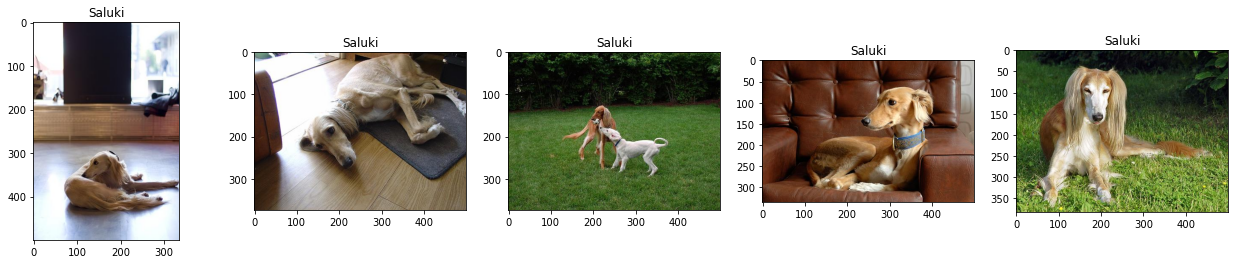

In [18]:
saluki_image_list = data_df[data_df['label']=='Saluki']['path'].tolist()
print("Count Saluki image: ", len(saluki_image_list))

saluki_image_list = data_df[data_df['label']=='Saluki']['path'].iloc[:5].tolist()

show_grid_images(saluki_image_list, ncols=5, title='Saluki')

***

## Prepare the datasets and generating menifest file

### This is the dog breed which was missing in the previous notebook or classified as a different dog breed
- Now, we are adding the Saluki dog breed images to the training dataset to improve the model

In [21]:
classes_to_be_trained = [
    "n02091831-Saluki"
]

holdoutset_list = {
    "n02091831-Saluki" : "./stanford_dog_dataset/images/Images/n02091831-Saluki/n02091831_3909.jpg"
}

In [22]:
training_dataset_list = []
test_dataset_list = []

# Generating new dataset for training and test
for class_nm in classes_to_be_trained:
    new_path_train = f'./stanford_dog_dataset/update_train_dataset/'
    makedirs(new_path_train, exist_ok=True)
    new_path_test = f'./stanford_dog_dataset/update_test_dataset/'
    makedirs(new_path_test, exist_ok=True)
    
    existing_path = f'./stanford_dog_dataset/images/Images/{class_nm}'
    
    onlyfiles = []
    
    for f in listdir(existing_path):
        if isfile(join(existing_path, f)):
            onlyfiles.append(join(existing_path, f))
    
    indices_for_splittin = [int(len(onlyfiles) * 0.8)]
    update_train_list, update_test_list = np.split(onlyfiles, indices_for_splittin)
    
    for train_file_path in update_train_list:
        training_dataset_list.append(train_file_path)
        dest_train_dataset_image_path = f'{new_path_train}/{train_file_path.split("/")[-1]}'
        shutil.copy(train_file_path, dest_train_dataset_image_path)
    
    for test_file_path in update_test_list:
        test_dataset_list.append(test_file_path)
        dest_test_dataset_image_path = f'{new_path_test}/{test_file_path.split("/")[-1]}'
        shutil.copy(test_file_path, dest_test_dataset_image_path)

print(f"Train/Test Split count - train:{len(training_dataset_list)}, test:{len(test_dataset_list)}")

Train/Test Split count - train:160, test:40


In [23]:
def generate_manifest_file(stanford_dog_dataset_annotation, final_manifest_file_path, dataset_type):
    final_file = []
    class_dict = {}
    
    for filename in stanford_dog_dataset_annotation:
#         print(filename)
        # Replace Image File Path -> Annotation File Path
        file_path = filename.replace('/images/Images/', '/annotation/Annotation/').replace('.jpg','')
        
        file = open(file_path, mode='r')
        annotation = file.read()
        
        single_file = {}
        
        root = ET.fromstring(annotation)
        
        image_size = {}
        image_nm = None
        
        for child in root:
            if child.tag == 'filename':
                image_nm = child.text # n02085620_10074
            if child.tag == 'size':
                for elem in child.iter():
                    if elem.tag == 'width':
                        image_size['width'] = int(elem.text)
                    if elem.tag == 'height':
                        image_size['height'] = int(elem.text)
                    if elem.tag == 'depth':
                        image_size['depth'] = int(elem.text)
        
        annotations = []
        objects = []
        class_map = {}
        
        object_info = root.findall('object')
        
        for obj in object_info:
            annotation = {}
            confidence = {}
            class_nm = None
            class_id = None
            for elem in obj.iter():
                if elem.tag == 'name':
                    class_nm = elem.text
                    class_id = class_dict.get(class_nm, None)
                    if class_id == None:
                        if len(class_dict) == 0:
                            class_id = 0
                        else:
                            all_values = class_dict.values()
                            max_value = max(all_values)
                            class_id = int(max_value) + 1
                        class_dict[class_nm] = class_id
                
                if elem.tag == 'bndbox':
                    xmin = ymin = xmax = ymax = 0
                    for sub_elem in elem.iter():
                        if sub_elem.tag == 'xmin':
                            xmin = int(sub_elem.text)
                        if sub_elem.tag == 'ymin':
                            ymin = int(sub_elem.text)
                        if sub_elem.tag == 'xmax':
                            xmax = int(sub_elem.text)
                        if sub_elem.tag == 'ymax':
                            ymax = int(sub_elem.text)
                    
                    annotation["class_id"] = class_id
                    annotation["top"] = ymin
                    annotation["left"] = xmin
                    annotation["width"] = xmax - xmin
                    annotation["height"] = ymax - ymin
                    annotations.append(annotation)
                    
                    confidence["confidence"] = 1
                    objects.append(confidence)
                    
                    class_map[class_id] = class_nm
            
        bounding_box = {
            "image_size": [image_size],
            "annotations": annotations
        }
        
        bounding_box_metadata = {
            "objects": objects,
            "class-map": class_map,
            "type": "groundtruth/object-detection",
            "human-annotated": "yes",
            "creation-date": datetime.today().strftime('%Y-%m-%dT%H:%m:%S'),
            "job-name": "testjob"
        }
        
        single_file = {
            "source-ref": f's3://{rek_cl_default_bucket}/stanford_dog_dataset/{dataset_type}/{image_nm}.jpg',
            "bounding-box": bounding_box,
            "bounding-box-metadata": bounding_box_metadata
        }
        
        image_json = json.dumps(single_file)
        final_file.append(image_json + "\n")
        file.close()
    
    manifest_file = open(final_manifest_file_path, "w")
    manifest_file.writelines(final_file)
    manifest_file.close()

### Generating updated train/test dataset manifest file

In [26]:
update_train_manifest_file_path = './stanford_dog_dataset/update_train_dataset/train_dataset.manifest'
update_test_manifest_file_path = './stanford_dog_dataset/update_test_dataset/test_dataset.manifest'

generate_manifest_file(training_dataset_list, update_train_manifest_file_path, 'update_train_dataset')
generate_manifest_file(test_dataset_list, update_test_manifest_file_path, 'update_test_dataset')

### Copy the train and test dataset to the Amazon Rekognition Custom Label default S3 bucket

In [27]:
!aws s3 cp ./stanford_dog_dataset/update_train_dataset/ s3://$rek_cl_default_bucket/stanford_dog_dataset/update_train_dataset/ --recursive --quiet
!aws s3 cp ./stanford_dog_dataset/update_test_dataset/ s3://$rek_cl_default_bucket/stanford_dog_dataset/update_test_dataset/ --recursive --quiet

***

## Retrieve an existing Rekognition Custom Labels Project details

In [28]:
project_nm = 'stanford_dogs_dataset_project'

custom_label_project = rekognition.describe_projects(
    ProjectNames=['stanford_dogs_dataset_project']
)

***

## Import the Datasets into the existing Project's training and test datasets
- we will use the train_dataset.maniest and test_dataset.manifest file which was created earlier,
- to update the existing training and test datasets.

In [30]:
project_arn = custom_label_project['ProjectDescriptions'][0]['ProjectArn']

training_dataset_arn = ""
test_dataset_arn = ""

for ds in custom_label_project['ProjectDescriptions'][0]['Datasets']:
    if ds['DatasetType'] == 'TRAIN':
        training_dataset_arn = ds['DatasetArn']
    else:
        test_dataset_arn = ds['DatasetArn']

print("Training dataset ARN: ", training_dataset_arn)
print("Test dataset ARN: ", test_dataset_arn)

Training dataset ARN:  arn:aws:rekognition:ap-northeast-2:057813195967:project/stanford_dogs_dataset_project/dataset/train/1647936592450
Test dataset ARN:  arn:aws:rekognition:ap-northeast-2:057813195967:project/stanford_dogs_dataset_project/dataset/test/1647937570697


In [32]:
s3_resource = boto3.resource("s3")

# Update training datasets
s3_object = s3_resource.Object(
    rek_cl_default_bucket,
    'stanford_dog_dataset/update_train_dataset/train_dataset.manifest'
)

s3_response = s3_object.get()

content = s3_response['Body'].read()

custom_label_update_dataset_train = rekognition.update_dataset_entries(
    DatasetArn=training_dataset_arn,
    Changes={
        'GroundTruth': content
    }
)

JSON(custom_label_update_dataset_train)

<IPython.core.display.JSON object>

In [33]:
# Update test datasets
s3_object = s3_resource.Object(
    rek_cl_default_bucket,
    'stanford_dog_dataset/update_test_dataset/test_dataset.manifest'
)

s3_response = s3_object.get()

content = s3_response['Body'].read()

custom_label_update_dataset_test = rekognition.update_dataset_entries(
    DatasetArn=test_dataset_arn,
    Changes={
        'GroundTruth': content
    }
)

In [34]:
chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(120)
    dataset_status_train = rekognition.describe_dataset(
        DatasetArn=training_dataset_arn
    )
    dataset_status_test = rekognition.describe_dataset(
        DatasetArn=test_dataset_arn
    )
    
    if (dataset_status_train['DatasetDescription']['Status'] != 'UPDATE_IN_PROGRESS') and \
        (dataset_status_test['DatasetDescription']['Status'] != 'UPDATE_IN_PROGRESS'):
        chk_status = False
    if (time.time() - start_time) > 3600:
        chk_status = False

JSON(dataset_status_test)

<IPython.core.display.JSON object>

In [35]:
JSON(dataset_status_train)

<IPython.core.display.JSON object>

***

## Train a Custom Model to detect two new Dog breeds

### Start Training the model

In [36]:
model_version_name = f'model_v{str(int(time.time()))}'

custom_label_model = rekognition.create_project_version(
    ProjectArn=project_arn,
    VersionName=model_version_name,
    OutputConfig={
        'S3Bucket': rek_cl_default_bucket,
        'S3KeyPrefix': 'stanford_dog_dataset/model_train_updated'
    }
)

JSON(custom_label_model)

<IPython.core.display.JSON object>

In [ ]:
chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(1800)
    model_training_status = rekognition.describe_project_versions(
        ProjectArn=project_arn,
        VersionNames=[
            model_version_name
        ]
    )
    
    if (model_training_status['ProjectVersionDescriptions'][0]['Status'] != 'TRAINING_IN_PROGRESS'):
        chk_status = False
    if (time.time() - start_time) > 3600:
        chk_status = False

JSON(model_training_status)

***

## Retrieve the Model Metrics

In [39]:
model_metrics = rekognition.describe_project_versions(
    ProjectArn=project_arn,
    VersionNames=[
        model_version_name
    ]
)

# Model Metrics
print("F1 Score " + str(model_metrics['ProjectVersionDescriptions'][0]['EvaluationResult']['F1Score']))

s3_resource = boto3.resource('s3')

content_object = s3_resource.Object(
    model_metrics['ProjectVersionDescriptions'][0]['EvaluationResult']['Summary']['S3Object']['Bucket'],
    model_metrics['ProjectVersionDescriptions'][0]['EvaluationResult']['Summary']['S3Object']['Name']
)

file_content = content_object.get()['Body'].read().decode('utf-8')
json_content = json.loads(file_content)

JSON(json_content)

F1 Score 0.9462674856185913


<IPython.core.display.JSON object>

***

## Start the trained model

In [40]:
start_model = rekognition.start_project_version(
    ProjectVersionArn=model_metrics['ProjectVersionDescriptions'][0]['ProjectVersionArn'],
    MinInferenceUnits=1
)

JSON(start_model)

<IPython.core.display.JSON object>

In [41]:
chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(300)
    model_start_status = rekognition.describe_project_versions(
        ProjectArn=project_arn,
        VersionNames=[
            model_version_name
        ]
    )
    
    if model_start_status['ProjectVersionDescriptions'][0]['Status'] != 'STARTING':
        chk_status = False
    if (time.time() - start_time) > 3600:
        chk_status = False

JSON(model_start_status)

<IPython.core.display.JSON object>

***

## Run tests on the holdout images

In [42]:
import boto3
import io
import logging
from PIL import Image, ImageDraw, ImageFont
from IPython.display import HTML, display

from botocore.exceptions import ClientError

logger = logging.getLogger(__name__)

def analyze_s3_image(rek_client, s3_connection, model, bucket, photo, min_confidence):
    """
    Analyzes an image stored in the specified S3 bucket.
    :param rek_client: The Amazon Rekognition Boto3 client.
    :param s3_connection: The Amazon S3 Boto3 S3 connection object.
    :param model: The ARN of the Amazon Rekognition Custom Labels model that you want to use.
    :param bucket: The name of the S3 bucket that contains the image that you want to analyze.
    :param photo: The name of the photo that you want to analyze.
    :param min_confidence: The desired threshold/confidence for the call.
    """
    
    try:
        logger.info("analyzing bucket: %s image: %s", bucket, photo)
        s3_object = s3_connection.Object(bucket, photo)
        s3_response = s3_object.get()
        
        stream = io.BytesIO(s3_response['Body'].read())
        image=Image.open(stream)
        
        image_type=Image.MIME[image.format]
        
        if (image_type == 'image/jpeg' or image_type == 'image/png') == False:
            logger.error("Invalid image type for %s", photo)
            raise ValueError(
                f"Invalid file format. Supply a jpeg or png format file: {photo}"
            )
        
        img_width, img_height = image.size
        draw = ImageDraw.Draw(image)
        
        # Call DetectCustomLabels
        response = rek_client.detect_custom_labels(
            Image={
                "S3Object":
                {
                    "Bucket": bucket,
                    "Name": photo
                }
            },
            MinConfidence=min_confidence,
            ProjectVersionArn=model
        )
        
        show_image(image, response)
        
        return len(response['CustomLabels'])
    
    except ClientError as err:
        logger.error(format(err))
        raise

def show_image(image, response):
    """
    Displays the analyzed image and overlays analysis results
    :param image: The analyzed image
    :param response: the response from DetectCustomLabels
    """
    try:
        font_size=10
        line_width=5
        
        img_width, img_height = image.size
        draw = ImageDraw.Draw(image)
        
        # calculate and display bounding boxes for each detected custom label
        image_level_label_height = 0
        
        for custom_label in response['CustomLabels']:
            confidence = int(round(custom_label['Confidence'], 0))
            label_text = f"{custom_label['Name']}:{confidence}%"
            fnt = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans.ttf", font_size)
            text_width, text_height = draw.textsize(label_text, fnt)
            
            logger.info(f"Label: {custom_label['Name']}")
            logger.info(f"Confidence: {confidence}%")
            
            # Draw bounding boxex, if present
            if 'Geometry' in custom_label:
                box = custom_label['Geometry']['BoundingBox']
                left = img_width * box['Left']
                top = img_height * box['Top']
                width = img_width * box['Width']
                height = img_height * box['Height']
                
                logger.info("Bounding box")
                logger.info("\tLeft: {0:.0f}".format(left))
                logger.info("\tTop: {0:.0f}".format(top))
                logger.info("\tLabel Width: {0:.0f}".format(width))
                logger.info("\tLabel Height: {0:.0f}".format(height))
                
                points = (
                    (left,top),
                    (left + width, top),
                    (left + width, top + height),
                    (left , top + height),
                    (left, top))
                
                #Draw bounding box and label text
                draw.line(points, fill="limegreen", width=line_width)
                draw.rectangle([(left + line_width , top+line_width), (left + text_width + line_width, top + line_width + text_height)],fill="black")
                draw.text((left + line_width ,top +line_width), label_text, fill="limegreen", font=fnt)
            
            #draw image-level label text.
            else:
                draw.rectangle([(10 , image_level_label_height), (text_width + 10, image_level_label_height+text_height)],fill="black")
                draw.text((10,image_level_label_height), label_text, fill="limegreen", font=fnt)  

                image_level_label_height += text_height
            
#         image.show()
        display(image)

    except Exception as err:
        logger.error(format(err))
        raise
        
def analyze_rekcl_bb(bckt_nm, pics, modelarn, minconfdnce):
    
    try:
        logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

        bucket=bckt_nm
        photos=pics
        model=modelarn
        min_confidence=minconfdnce
       

        rek_client=boto3.client('rekognition')
        
        s3_connection = boto3.resource('s3')
        for photo in photos:
            label_count=analyze_s3_image(rek_client,
                s3_connection,
                model,
                bucket,
                photo,
                min_confidence)
            
            
            
            

        """
        # Uncomment to analyze a local file. 
        # Change photo to the path and file name of a local file.
        label_count=analyze_local_image(rek_client,
            model,
            photo,
            min_confidence)
        
        """ 
        logger.info(f"Custom labels detected: {label_count}")

    except ClientError as err:
        print("A service client error occurred: " + format(err.response["Error"]["Message"]))
    except ValueError as err:
        print ("A value error occurred: " + format(err))

### Test the model on the holdout dataset

INFO: analyzing bucket: custom-labels-console-ap-northeast-2-848d0c39c9 image: stanford_dog_dataset/holdout/Saluki.jpg
INFO: Label: Saluki
INFO: Confidence: 100%
INFO: Bounding box
INFO: 	Left: 79
INFO: 	Top: 103
INFO: 	Label Width: 140
INFO: 	Label Height: 159


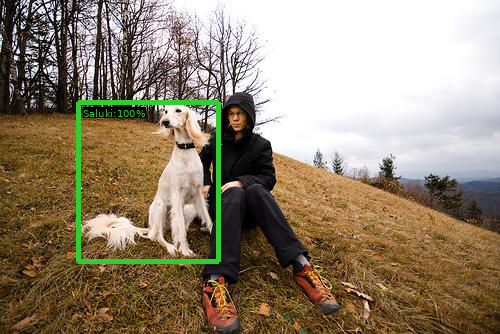

INFO: analyzing bucket: custom-labels-console-ap-northeast-2-848d0c39c9 image: stanford_dog_dataset/holdout/Doberman.jpg
INFO: Label: Doberman
INFO: Confidence: 100%
INFO: Bounding box
INFO: 	Left: 20
INFO: 	Top: 6
INFO: 	Label Width: 328
INFO: 	Label Height: 275


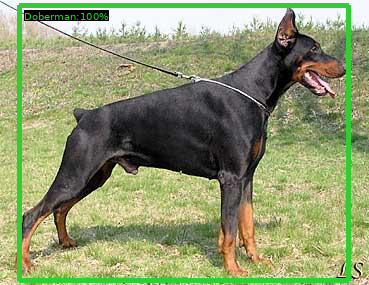

INFO: analyzing bucket: custom-labels-console-ap-northeast-2-848d0c39c9 image: stanford_dog_dataset/holdout/redbone.jpg
INFO: Label: redbone
INFO: Confidence: 100%
INFO: Bounding box
INFO: 	Left: 130
INFO: 	Top: 18
INFO: 	Label Width: 214
INFO: 	Label Height: 354


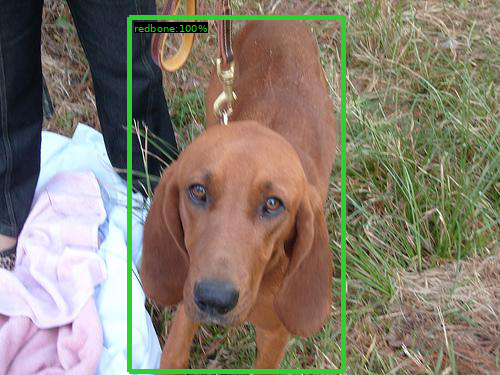

INFO: analyzing bucket: custom-labels-console-ap-northeast-2-848d0c39c9 image: stanford_dog_dataset/holdout/golden_retriever.jpg
INFO: Label: golden_retriever
INFO: Confidence: 100%
INFO: Bounding box
INFO: 	Left: 94
INFO: 	Top: 1
INFO: 	Label Width: 296
INFO: 	Label Height: 331


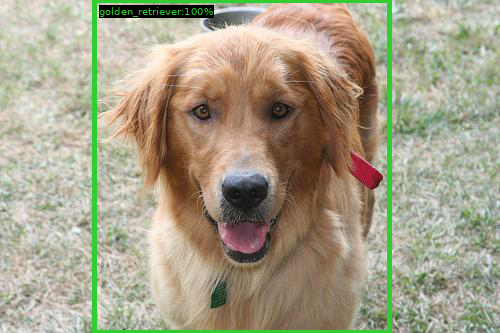

INFO: Custom labels detected: 1


In [43]:
bucket_nm = rek_cl_default_bucket

holdout_photos = []

for f in listdir('./stanford_dog_dataset/holdout'):
    if (isfile(join('./stanford_dog_dataset/holdout', f)) and (f.split(".")[-1]) == 'jpg'):
        holdout_photos.append(('stanford_dog_dataset/holdout/' + f))

model_arn = model_metrics['ProjectVersionDescriptions'][0]['ProjectVersionArn']
min_confidence = 70

analyze_rekcl_bb(bucket_nm, holdout_photos, model_arn, min_confidence)

***

## Stop the trained model

In [44]:
stop_model = rekognition.stop_project_version(
    ProjectVersionArn=model_metrics['ProjectVersionDescriptions'][0]['ProjectVersionArn']
)

JSON(stop_model)

<IPython.core.display.JSON object>

In [45]:
chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(300)
    model_stop_status = rekognition.describe_project_versions(
        ProjectArn=project_arn,
        VersionNames=[
            model_version_name
        ]
    )
    
    if model_stop_status['ProjectVersionDescriptions'][0]['Status'] !=' STOPPING':
        chk_status = False
    if (time.time() - start_time) > 3600:
        chk_status = False

JSON(model_stop_status)

<IPython.core.display.JSON object>